# Анализ рынка недвижимости города Санкт-Петербург

Задача проекта: используя данные сервиса Яндекс.Недвижимость, определить рыночную стоимость объектов недвижимости и типичные параметры квартир.
Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основании картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('C:/Users/Student/Desktop/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://drive.google.com/drive/datasets/real_estate_data.csv', sep='\t')

data.info()
pd.set_option('display.max_columns', None)    
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


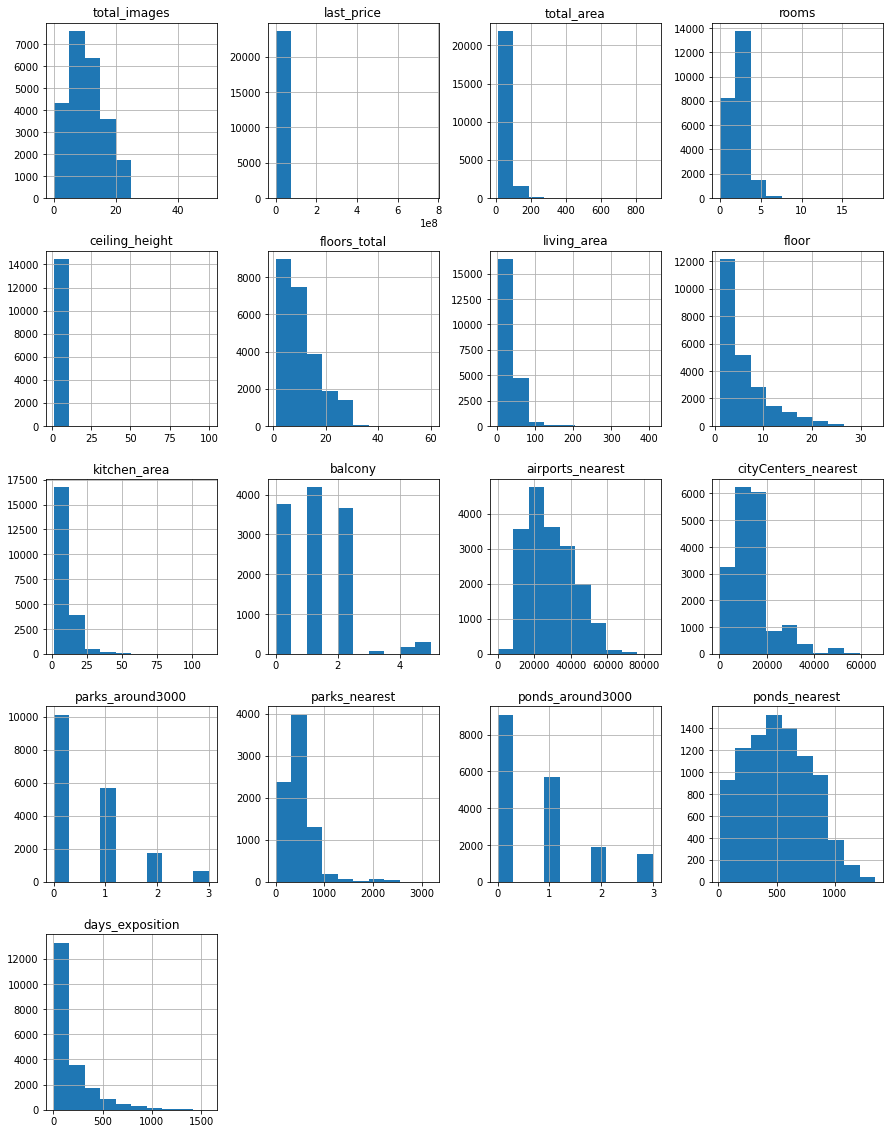

In [3]:
data.hist(figsize=(15,20));

По укрупненным графикам нельзя сказать ничего конкретного, но видно, что необходима обработка данных. Избавиться от пропусков и выбросов, удалить дубликаты, заменить тип данных в столбце с датой и привести данные в приемлемый вид.

### Предобработка данных

#### Работа с пропущенными значениями

Проверим в каких столбцах и в каком количестве присутствуют пропущенные значения.

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Начнем со столбца со значениями высоты потолка. Поскольку в среднем потолки в квартирах бывают плюс-минус одной высоты, проверим медианное значение для них в нашем датафрейме.

2.65

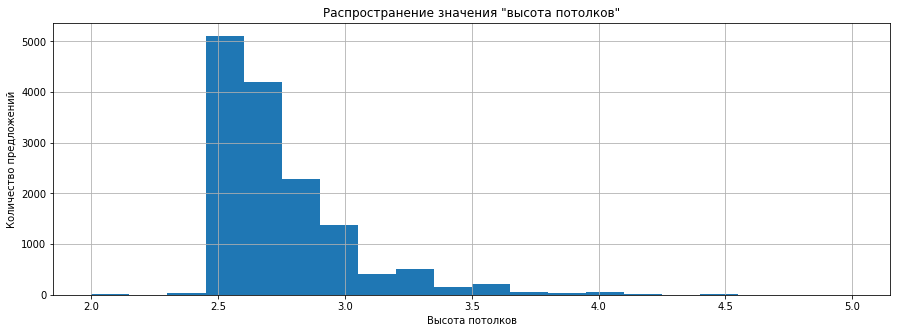

In [5]:
data['ceiling_height'].hist(bins=20, range=(2,5), figsize=(15,5))
plt.title('Распространение значения "высота потолков"')
plt.xlabel('Высота потолков')
plt.ylabel('Количество предложений');
data['ceiling_height'].median()

Высота 2,6м что как раз соответствует стандартному значению высоты потолков, используем ее. И заодно проверим, остались ли пропущенные значения в нашем датафрейме.

In [6]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum()

0

В столбце со значениями общей площади пропусков нет, а вот в столбце со значениями жилой площади появились пропуски. Считаю, что данные пропуски необходимо заполнить медианными значениями по сгруппированным по количеству квартир значениям.

In [7]:
data.pivot_table(index='rooms', values = 'living_area', aggfunc=['median', 'mean'])

,median,mean
,living_area,living_area
rooms,,
0,18.000,18.865246
1,17.600,17.893552
2,30.500,31.736849
3,45.000,47.387941
4,63.600,66.983223
5,91.785,100.009247
6,123.900,130.983636
7,145.000,163.564151


Вероятнее всего, что количество комнат = 0 указывали, если квартира является студией, проверим это.

In [8]:
print('Объявлений о продаже квартир-студий с количеством комнат 0 :', data.query("studio==True and rooms==0")["studio"].sum(), 'объявлений')

Объявлений о продаже квартир-студий с количеством комнат 0 : 138 объявлений


In [9]:
print('Всего объявлений о продаже квартир-студий :', data.query('studio==True')['floor'].count(), 'объявлений')

Всего объявлений о продаже квартир-студий : 149 объявлений


In [10]:
print('Всего объявлений о продаже квартир с количеством квартир 0 :', data.query("rooms==0")['rooms'].count(), 'объявлений')

Всего объявлений о продаже квартир с количеством квартир 0 : 197 объявлений


Предположение оказалось верным, люди указывали количество комнат 0, если они продают студию. Заменим данные значения на 1. Но всего объявлений оказалось 197. Считаю, что оставшиеся 59 объявлений можно удалить из нашего датафрейма без вреда для дальнейшего анализа.

In [11]:
def z (row):
    x=row['rooms']
    y=row['studio']
    if x==0:
        if y==True:
            return 1
        else:
            return x
    else:
        return x
data['rooms'] = data.apply(z, axis=1)

In [12]:
data = data[data['rooms']!=0]

Вернемся к заполнению пропусков и заполним пропуски в столбце жилая площадь.

In [13]:
for x in data['rooms'].unique():
    data.loc[(data['rooms'] == x) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == x), 'living_area'].median()

In [14]:
print('Количество пропусков =', data['living_area'].isna().sum())

Количество пропусков = 0


Если пропущено значение в столбце 'is apartment', считаем, что значение = False

In [15]:
data['is_apartment'] = data['is_apartment'].fillna(False)

In [16]:
print('Количество пропусков =', data['is_apartment'].isna().sum())

Количество пропусков = 0


Пропущенные значения площади кухни заполним медианными значениями этого столбца.

In [17]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
print('Количество пропусков =', data['kitchen_area'].isna().sum())

Количество пропусков = 0


Пропущенные значения количества балконов заполним 0, так как скорее всего люди пропускали этот пункт при отсутствии у них балконов.

In [18]:
data['balcony'] = data['balcony'].fillna(0)
print('Количество пропусков =', data['balcony'].isna().sum())

Количество пропусков = 0


Остальные значения логически заполнить нельзя.

#### Заменяем типы значений

Изменим тип значений в столбце "first_day_exposition"

In [19]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### Изучаем уникальные значения

Проанализируем наименования населенных пунктов и посчитаем их количество.

In [20]:
print(data['locality_name'].unique())
data['locality_name'].nunique()

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

363

In [21]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('городской ', '')
data['locality_name'] = data['locality_name'].str.replace('городского типа ', '')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ', '')
data['locality_name'].nunique()

320

Избавились от неявных дубликатов в названиях и снизили количество наименований на 12%.

#### Удаляем выбросы

Удалим выбросы значений высоты потолков и проверим высоту потолков в оставшихся объявлениях.

In [22]:
def height(x):
    if 22<=x<=40:
        return (x/10)
    else:
        return x
data['ceiling_height'] = data['ceiling_height'].apply(height)
data = data[data['ceiling_height'] < 10] #отметаем оставшиеся значения больше 10 м, т.к. они больше похожи на выбросы
data = data[data['ceiling_height'] >= 1.8] #значения меньше 1.8м тоже уберем, т.к. скорее всего эти значения тоже будут выбросами
data['ceiling_height'].sort_values().unique()

array([2.  , 2.2 , 2.25, 2.26, 2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48,
       2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59,
       2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 ,
       2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81,
       2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92,
       2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03,
       3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14,
       3.15, 3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26,
       3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37,
       3.38, 3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49,
       3.5 , 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 ,
       3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78,
       3.8 , 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95,
       3.98, 4.  , 4.06, 4.1 , 4.14, 4.15, 4.19, 4.

Видим, что есть квартиры с высотой потолков больше 4 метров. Проверим, сколько таких в датафрейме

In [23]:
print('Квартир, с потолками выше 4 метров -', data.query('ceiling_height>=4')['ceiling_height'].count(), 'квартир')

Квартир, с потолками выше 4 метров - 89 квартир


Такие потолки имеют место быть, но для нашего анализа, скорее всего, эти данные будут аномальными и будут мешать нашей работе. Избавимся от них.

In [24]:
data = data[data['ceiling_height']<=4]

Проверим максимальное количество этажей в домах, где продаются квартиры.

In [25]:
data['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 52., 60., nan])

Значения этажности зданий считаем нормальными.

In [26]:
print(f'Квартир с площадью больше 200м^2= {data[data["total_area"]>200]["total_area"].count()} квартир')

Квартир с площадью больше 200м^2= 214 квартир


Это меньше 1% от общего количества объявлений. Считаю, что можем удалить данные объявления из датафрейма.

In [27]:
data = data[data['total_area']<=200]

Проверим на выбросы количество балконов в продаваемых квартирах.

In [28]:
data['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

Количество балконов в пределах нормы.

Также проверим на выбросы столбец площадь кухни.

In [29]:
data['kitchen_area'].max()

93.2

Допустим, что кухня 93.2 кв. м. может быть

Проверим на выбросы столбец с ценой квартир дороже 30 млн. руб.

In [30]:
data.query('last_price>30000000')['last_price'].count()

181

Считаю, что квартиры, дороже 30 млн. руб., ввиду их незначительного количества в нашем датафрейме, для нашего анализа не нужны.

In [31]:
data = data[data['last_price']<30000000]

И последнее, проверим значения количества комнат в объявлениях.

In [32]:
print('Объявлений о продаже квартир с количеством комнат больше 5:', data[data['rooms']>5]['rooms'].count())

Объявлений о продаже квартир с количеством комнат больше 5: 79


Считаю, что для нашего анализа достаточно квартир с количеством комнат до 5

In [33]:
data = data[data['rooms']<=5]

### Посчитаем и добавим в таблицу новые столбцы

Добавим в таблицу новые столбцы:

price_per_m - цена за квадратный метр

weekday - день размещения объявления

month - месяц размещения объявления

year - год размещения объявления

floor_type - тип этажа, где 1 этаж - первый, последний этаж - последний, а все остальные - другой

In [34]:
data['price_per_m'] = data['last_price']/data['total_area']

In [35]:
data['weekday'] = data['first_day_exposition'].dt.weekday

In [36]:
data['month'] = data['first_day_exposition'].dt.month

In [37]:
data['year'] = data['first_day_exposition'].dt.year

In [38]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor==floors_total:
        return 'последний'
    elif floor==1:
        return 'первый'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

In [39]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)

### Исследовательский анализ данных

#### Изучим параметры объектов.

Выведем сводную таблицу для интересующих нас значений.

In [40]:
table_itog = data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area','last_price'], aggfunc=['median'])
table_itog_count = data.pivot_table(index='rooms', values=['total_area'], aggfunc=['count'])
table_itog = table_itog.join(table_itog_count)
table_itog.columns=['Площадь кухни','Цена', 'Жилая площадь', 'Общая площадь', 'Всего объявлений с квартирами']
table_itog

,Площадь кухни,Цена,Жилая площадь,Общая площадь,Всего объявлений с квартирами
rooms,,,,,
1,9.1,3590000.0,17.6,36.4,8167
2,9.0,4750000.0,30.5,53.0,7908
3,9.1,6100000.0,45.0,72.2,5692
4,10.0,8500000.0,63.6,96.0,1090
5,13.0,12000000.0,89.2,129.8,245


Построим гистограммы.

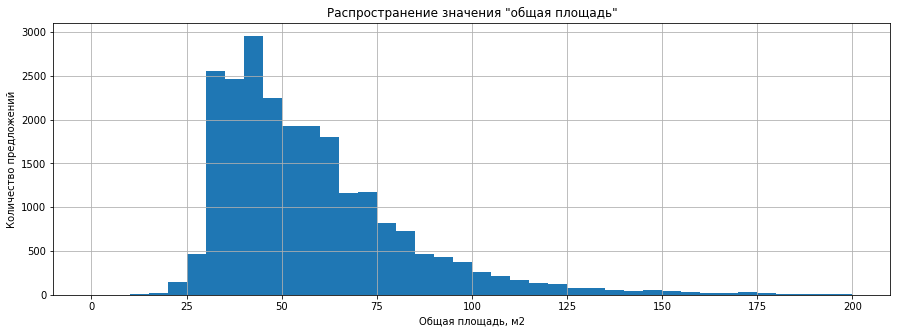

In [41]:
data['total_area'].hist(bins=40, range=(0,200), figsize=(15,5))
plt.title('Распространение значения "общая площадь"')
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 200 кв. м. так как он показывает наиболее распространенные значения площади квартир. Из гистограммы видно, что самой распространенной площадью для квартиры является диапазон от 30 до 45 кв.м.

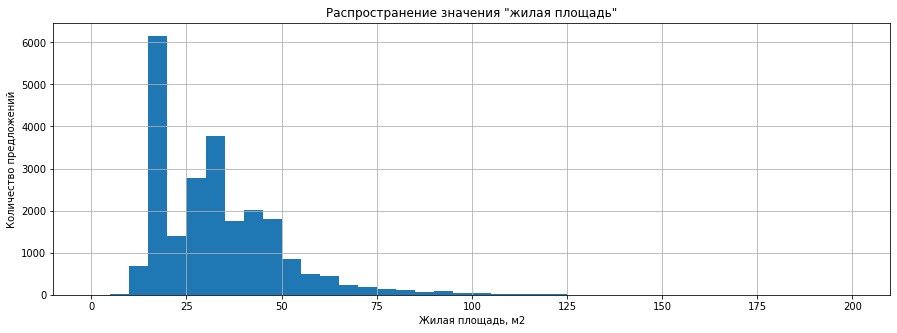

In [42]:
data['living_area'].hist(bins=40, range=(0,200), figsize=(15,5))
plt.title('Распространение значения "жилая площадь"')
plt.xlabel('Жилая площадь, м2')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 200 кв. м. так как он показывает наиболее распространенные значения жилой площади квартир. Пик находится на значениях 15 - 20 кв.м., что соответствует жилой площади однокомнатной квартиры. Также, рост гистограммы наблюдается в значениях от 25 до 35 кв.м., что соответствует жилой площади двухкомнтаной квартиры, которых в продаже примерно как и однокомнатных.

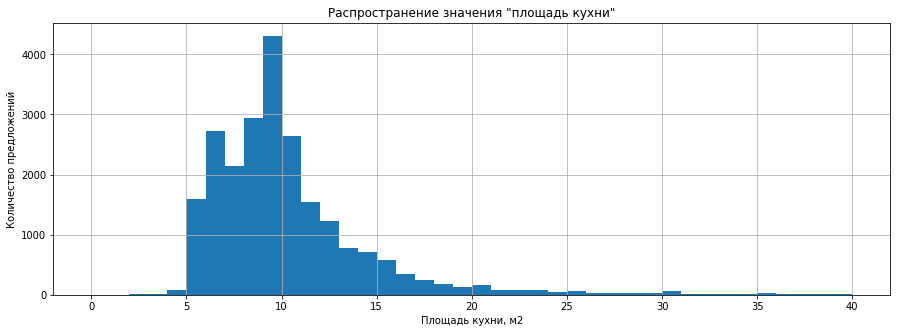

In [43]:
data['kitchen_area'].hist(bins=40, range=(0,40), figsize=(15,5))
plt.title('Распространение значения "площадь кухни"')
plt.xlabel('Площадь кухни, м2')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 40 кв. м. так как он показывает наиболее распространенные значения площади кухни. Самое распространенное значение площади кухни 9 кв.м.

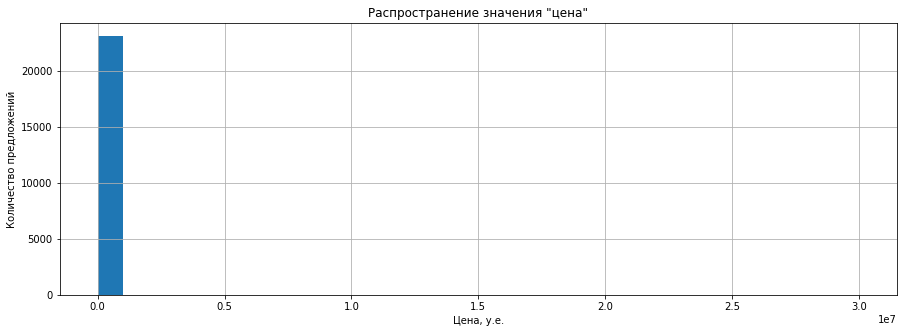

In [44]:
data['last_price'] = data['last_price'] / 1000000
data['last_price'].hist(bins=30, range=(0,30000000), figsize=(15,5))
plt.title('Распространение значения "цена"')
plt.xlabel('Цена, у.е.')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 30 млн. р. так как он показывает наиболее распространенные значения стоимости квартиры. Пики гистограммы соответствуют значениям от 3 до 5 млн. р.

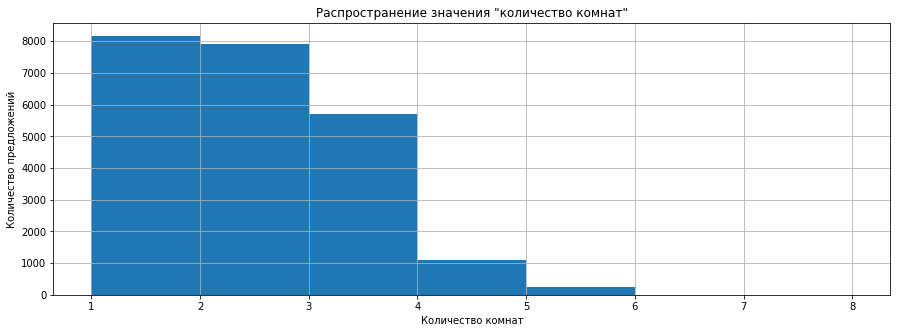

In [45]:
data['rooms'].hist(bins=7, range=(1,8), figsize=(15,5))
plt.title('Распространение значения "количество комнат"')
plt.xlabel('Количество комнат')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 1 до 8, так как он показывает наиболее распространенные значения количества комнат в квартире. По гистограмме видно, что однокомнатных и двухкомнатных квартир продавалось практически одинаковое количество, около 8 тысяч объявлений для каждой соответственно, на 2 тысячи меньше объявлений о трехкомнатных квартирах и немного больше тысячи объявлений о четырехкомнатных. Начиная с квартир с 5 комнатами объявлений менее 3% от общего количества.

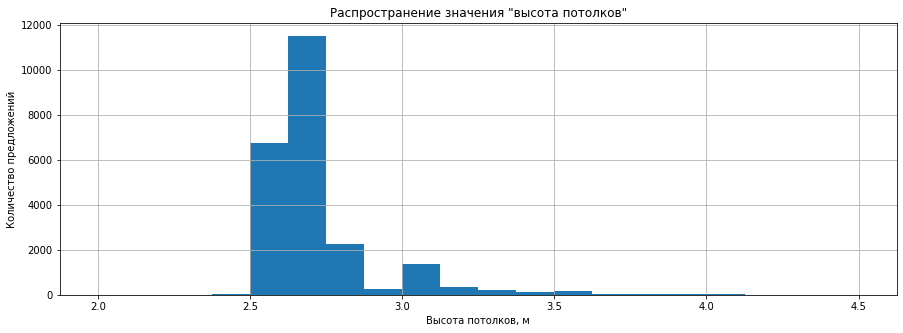

In [46]:
data['ceiling_height'].hist(bins=20, range=(2,4.5), figsize=(15,5))
plt.title('Распространение значения "высота потолков"')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 2 до 5 м, так как он показывает наиболее распространенные значения высоты потолков в квартире. Наиболее распространенной высотой потолка в квартире является медианное значение - 2.65, что является стандартным значением.

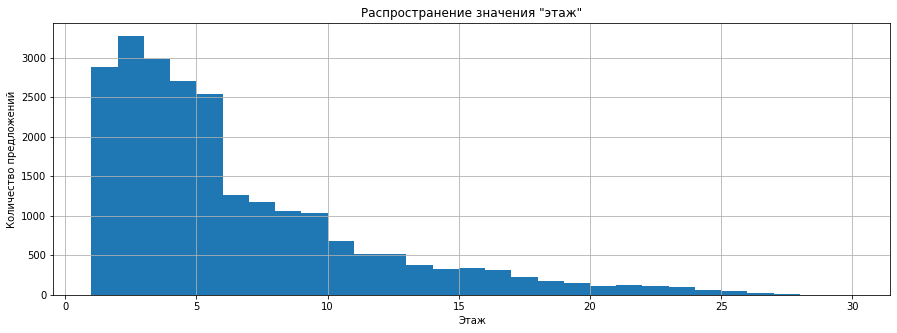

In [47]:
data['floor'].hist(bins=29, range=(1,30), figsize=(15,5))
plt.title('Распространение значения "этаж"')
plt.xlabel('Этаж')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 1 до 30 этажа, так как он показывает наиболее распространенные значения этажа квартиры. Больше всего объявлений до 5 этажа, что позволяет нам предположить, что чаще всего продаются квартиры в "хрущевках", у которых обычно 5 этаж - последний.

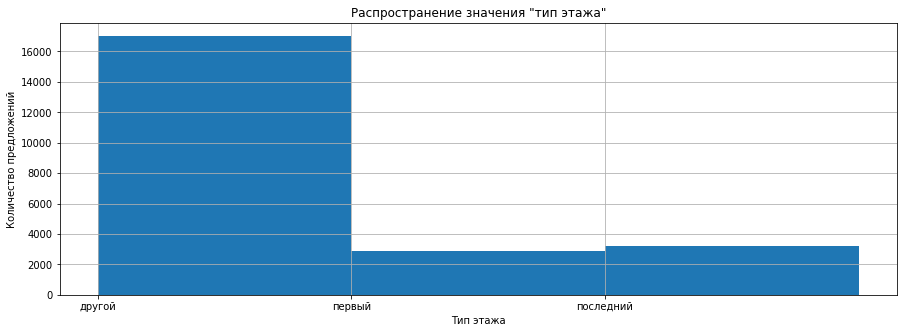

In [48]:
data['floor_type'].hist(bins=3, range=(0,3), figsize=(15,5))
plt.title('Распространение значения "тип этажа"')
plt.xlabel('Тип этажа')
plt.ylabel('Количество предложений');

Более распространены предложения с квартирами на промежуточных этажах.

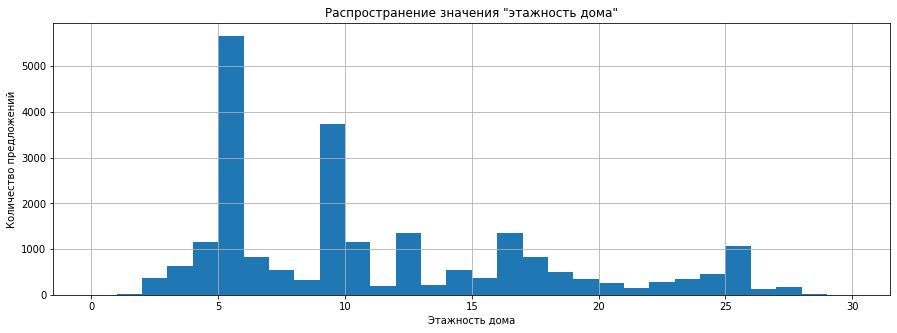

In [49]:
data['floors_total'].hist(bins=30, range=(0,30), figsize=(15,5))
plt.title('Распространение значения "этажность дома"')
plt.xlabel('Этажность дома')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 1 до 30 этажа, так как он показывает наиболее распространенные значения этажности дома. Предположение подтвердилось, наиболее частым объявлением о продаже является квартира в пятиэтажном доме. Следующим, по количеству выложенных объявлений о продаже является девятиэтажный дом. 

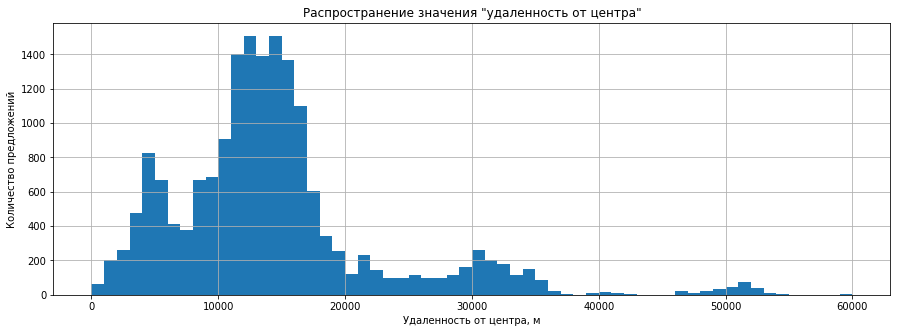

In [50]:
data['cityCenters_nearest'].hist(bins=60, range=(0,60000), figsize=(15,5))
plt.title('Распространение значения "удаленность от центра"')
plt.xlabel('Удаленность от центра, м')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 60 км, так как он показывает наиболее распространенные значения удаленности дома от центра города. Больше всего объявлений о продаже квартиры, которые находятся в 11-14 км от центра города. Также пик наблюдается ближе к центру города, около 5-6 км от центра. 

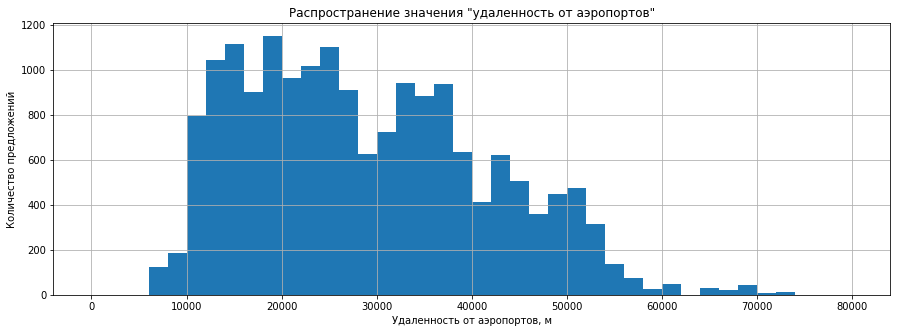

In [51]:
data['airports_nearest'].hist(bins=40, range=(0,80000), figsize=(15,5))
plt.title('Распространение значения "удаленность от аэропортов"')
plt.xlabel('Удаленность от аэропортов, м')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 80 км, так как он показывает наиболее распространенные значения удаленности дома от аэропортов. Основное количество домов в объявлениях о продаже квартиры находятся в диапазоне от 10 до 50 км.

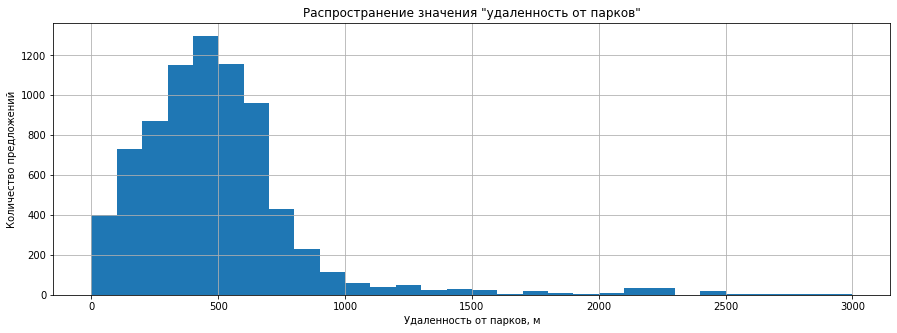

In [52]:
data['parks_nearest'].hist(bins=30, range=(0,3000), figsize=(15,5))
plt.title('Распространение значения "удаленность от парков"')
plt.xlabel('Удаленность от парков, м')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 3 км, так как он показывает наиболее распространенные значения удаленности дома от парков. Основное количество домов в объявлениях о продаже квартиры находятся в пешей доступности до парков, чаще всего меньше 1 км. 

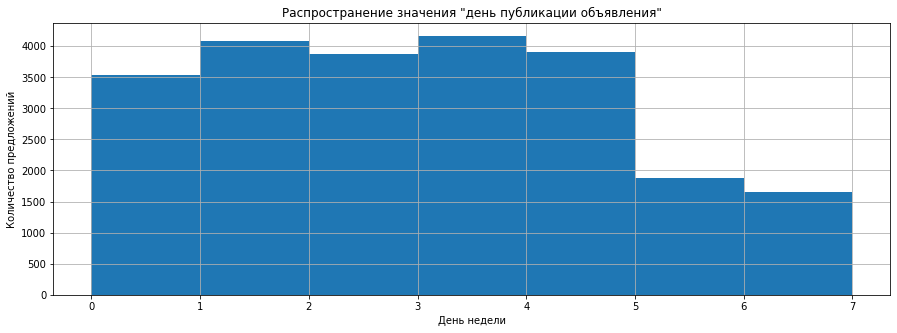

In [53]:
data['weekday'].hist(bins=7, range=(0,7), figsize=(15,5))
plt.title('Распространение значения "день публикации объявления"')
plt.xlabel('День недели')
plt.ylabel('Количество предложений');

Для построения гистограммы выберем диапазон от 0 до 7, который отобразит нам все дни недели, в которые выкладывались объявления. Из гистограммы видно, что чаще объявления выкладываются в будний день. Можно предположить, что у людей меньший интерес заниматься выкладыванием объявлений в выходные, чем в будний день. Также это может быть обусловлено работой агенств недвижимости, которые занимаются этим в рабочее время в будний день.

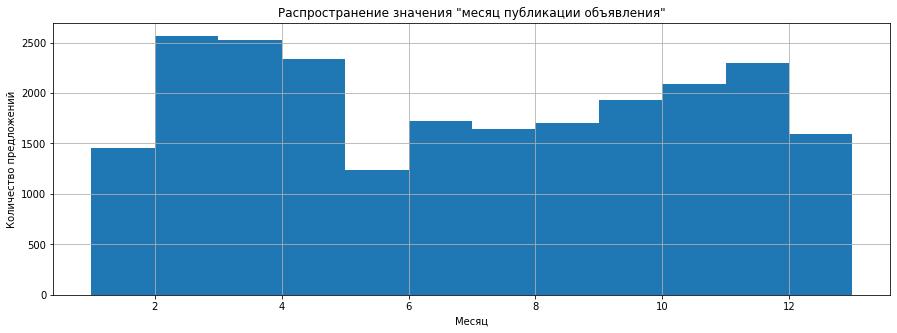

In [54]:
data['month'].hist(bins=12, range=(1,13), figsize=(15,5))
plt.title('Распространение значения "месяц публикации объявления"')
plt.xlabel('Месяц')
plt.ylabel('Количество предложений');

Всех больше объявлений выкладывают с февраля по апрель, в мае количество выкладываемых объявлений резко уменьшается и далее постепенно возрастает но начала зимы. В декабре и январе примерно одинаковое среднее количество выкладываемых объявлений. Объединим итоги этой гистограммы в п. 4.3, когда будем считать зависимость стоимости квартиры от месяца.

#### Изучим скорость продажи квартиры

Для начала построим график зависимости количества комнат в квартире от срока продажи.

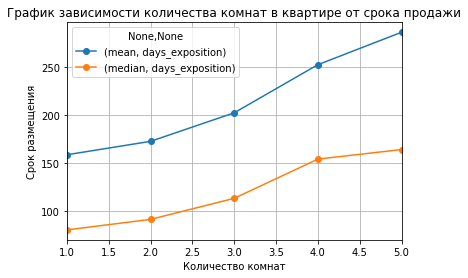

In [55]:
data.pivot_table(index='rooms', values='days_exposition', aggfunc=['mean', 'median']).plot(xlim=(1,5), style='o-', grid=True)
plt.title('График зависимости количества комнат в квартире от срока продажи')
plt.xlabel('Количество комнат')
plt.ylabel('Срок размещения');

Из графика видна тенденция увеличения срока размещения от увеличения количества комнат в квартире.

Теперь построим общую гистограмму по длительности размещения объявления и посчитаем среднее и медианное значения.

Медианное значение срока размещения объявления = 95 дней
Среднее значение срока размещения объявления = 179 дней


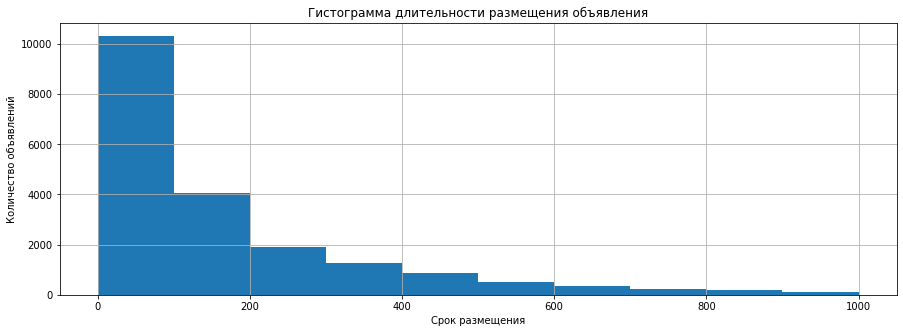

In [56]:
data['days_exposition'].hist(bins=10, range=(0,1000), figsize=(15,5))
plt.title('Гистограмма длительности размещения объявления')
plt.xlabel('Срок размещения')
plt.ylabel('Количество объявлений');
print(f'Медианное значение срока размещения объявления = {round(data["days_exposition"].median())} дней')
print(f'Среднее значение срока размещения объявления = {round(data["days_exposition"].mean())} дней')

Примем, что срок размещения квартиры является промежутком времени между размещением объявления и продажей квартиры. Из графика и гистограммы можно сделать вывод, что квартиры с меньшим количеством комнат продаются быстрее, примерно за 100 дней, что соответствует медианному значению срока размещения объявления, но также в данных присутствуют и квартиры со сроком размещения до 1000 дней.

#### Зависимость цены от разных факторов

Проверим зависимость цены от общей площади квартиры. Построим график рассеяния и посчитаем коэффициент Пирсона.

0.7818369971309496

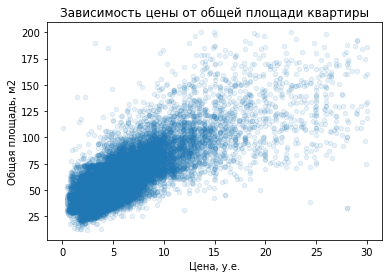

In [57]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.1)
plt.title('Зависимость цены от общей площади квартиры')
plt.xlabel('Цена, у.е.')
plt.ylabel('Общая площадь, м2');
data['last_price'].corr(data['total_area'])

По графику и коэффициенту Пирсона видно, что зависимость прямая. Чем больше площадь квартиры, тем она дороже.

Проверим зависимость цены от жилой площади квартиры.

0.6392331961426242

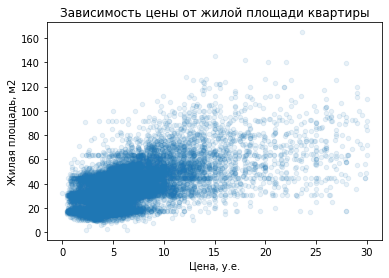

In [58]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.1)
plt.title('Зависимость цены от жилой площади квартиры')
plt.xlabel('Цена, у.е.')
plt.ylabel('Жилая площадь, м2');
data['last_price'].corr(data['living_area'])

Коэффициент Пирсона уже меньше, но все равно сохраняется прямая зависимость, чем больше жилая площадь квартиры, тем она дороже.

Проверим зависимость цены квартиры от площади кухни.

0.5646176138670056

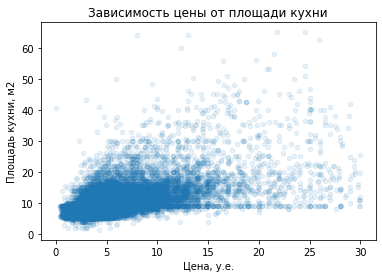

In [59]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.1)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Цена, у.е.')
plt.ylabel('Площадь кухни, м2');
data['last_price'].corr(data['kitchen_area'])

Сохраняется прямая зависимость, но уже не такая явная, как в предыдущих графиках. Скорее всего площадь кухни не является основным фактором при выборе квартиры, а прямая зависимость сохраняется лишь потому, что при увеличении общей площади квартиры чаще всего увеличивается площадь кухни.

Проверим зависимость стоимости квартиры от количества комнат.

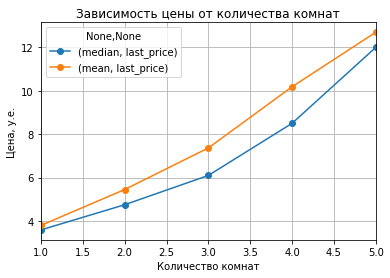

In [60]:
data.pivot_table(index='rooms', values='last_price', aggfunc=['median', 'mean']).plot(xlim=(1,5), style='o-', grid=True)
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена, у.е.');

Стоимость квартир напрямую зависит от количества комнат в квартире.

Проверим зависимость стоимости квартиры от этажа, на котором расположена квартира.

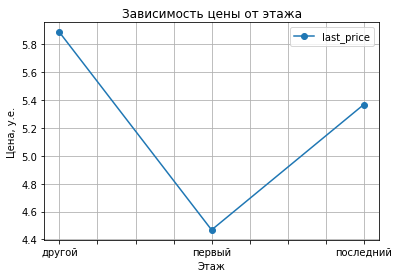

In [61]:
data.pivot_table(index='floor_type', values='last_price').plot(style='o-', grid=True)
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена, у.е.');

Из графика видим, что самые дешевые квартиры располагаются на 1 этаже. Квартиры на последнем этаже также стоят дешевле других, но, видимо, пользуются большим успехом и их стоимость больше, чем у квартир на первом этаже.

Проверим зависимость стоимости от даты публикации, а именно от дня, месяца и года.

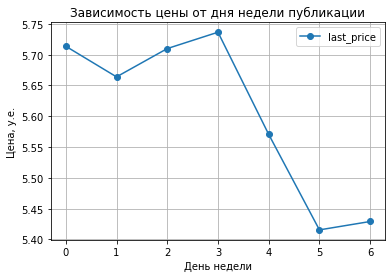

In [62]:
data.pivot_table(index='weekday', values='last_price').plot(style='o-', grid=True)
plt.title('Зависимость цены от дня недели публикации')
plt.xlabel('День недели')
plt.ylabel('Цена, у.е.');

Сделаем выводы по графику зависимости стоимости квартиры от дня публикации. Цены выкладываемых квартир на выходных в среднем ниже, чем стоимости квартир, которые были выложены на неделе. Как и предполагалось раньше, это может быть обусловлено работой агенств недвижимости, которые выкладывают объявления со своей наценкой в будние дни. А частные продавцы выкладывают объявления в свободное от работы время, на выходных, без наценки.

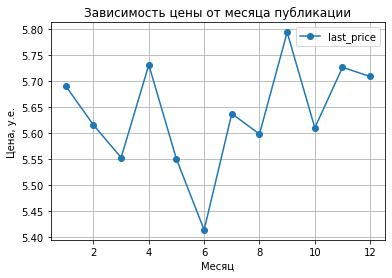

In [63]:
data.pivot_table(index='month', values='last_price').plot(style='o-', grid=True)
plt.title('Зависимость цены от месяца публикации')
plt.xlabel('Месяц')
plt.ylabel('Цена, у.е.');

Объявления о самых дорогих квартирах размещаются в сентябре, и примерно одинаковая цена у объявлений, которые были выложены в январе, апреле, ноябре и декабре. Минимальная цена в объявлениях о продаже квартир в июне. Попробуем предположить о причинах таких значений.

В сентябре, возможно, самые дорогие квартиры из-за окончания сезона отпусков, спрос на рынке растет и соответственно растут цены. Также это может быть обусловлено началом учебного года, родители покупают своим детям, поступившим в вузы и институты квартиры для проживания. Интерес сохраняется до Нового Года.

Апрель, скорее всего начало весны провоцирует людей на перемены в жизни, отсюда появляется спрос на квартиры и соответственно растет цена.

Начиная с мая, на праздниках людям не так интересна покупка нового жилья, а также летом, когда идет сезон отпусков.

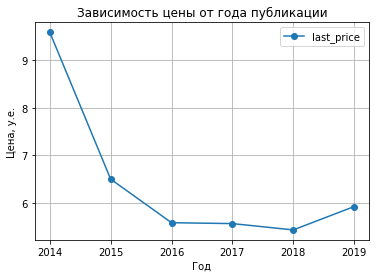

In [64]:
data.pivot_table(index='year', values='last_price').plot(style='o-', grid=True)
plt.title('Зависимость цены от года публикации')
plt.xlabel('Год')
plt.ylabel('Цена, у.е.');

Из графика зависимости цены от года публикации объявления можно сделать вывод, что в 2014 году был пик продажи дорогих квартир и далее на рынке виден заметный спад цен на квартиры.



#### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Соберем сводную таблицу из 10 населенных пунктов с наибольшим количеством объявлений и посчитаем среднюю цену квадратного метра в этих населенных пунктах.

In [65]:
data_mean_price = data.pivot_table(index='locality_name', values='price_per_m', aggfunc=['count', 'mean'])
data_mean_price.columns=['Количество объявлений', 'Средняя цена квадратного метра']
data_mean_price_sorted = data_mean_price.sort_values(by='Количество объявлений', ascending = False)[:10]
data_mean_price_sorted = data_mean_price_sorted.sort_values(by='Средняя цена квадратного метра', ascending = False)
data_mean_price_sorted

,Количество объявлений,Средняя цена квадратного метра
locality_name,,
Санкт-Петербург,15181,110571.382905
Пушкин,362,103145.135041
деревня Кудрово,287,92312.310411
поселок Парголово,323,90348.996281
поселок Мурино,549,85503.698732
поселок Шушары,440,78677.364217
Колпино,337,75333.295801
Гатчина,307,68746.146763
Всеволожск,397,68605.572959


Самые дорогие квартиры в Санкт-Петербурге, все хотят жить в городе. Далее, по нисходящей распложены города-туристические центры и стоимость квартир в Пушкине практически достигает средней цены в самом Питере. Не зря до революции этот город называли Царским селом.

Вернемся к шагу 4.2 и разберемся в причинах появления таких значений. Проверим теорию, что большиство объявлений со сроком продажи больше медианного значения имеют завышенную цену за квадратный метр.

In [66]:
data = data.merge(data_mean_price, on='locality_name')
def x (row):
    y=0
    price_per_m = row['price_per_m']
    price_per_m_mean = row['Средняя цена квадратного метра']
    days_expo = row['days_exposition']
    median = 95
    if days_expo > median:
        if price_per_m > price_per_m_mean:
            y +=1
            return y

print('Количество объявлений квартир с долгим сроком размещения и завышенной ценой за квадратный метр =', data.apply(x, axis=1).count())
print('Всего объявлений с долгим сроком размещения=', data[data['days_exposition']>95]['days_exposition'].count())

    

Количество объявлений квартир с долгим сроком размещения и завышенной ценой за квадратный метр = 3933
Всего объявлений с долгим сроком размещения= 9938


Теория не подтвердилась, но нельзя сказать, что мы ее опровергли. Таких объявлений оказалось практически 40%. Людям действительно не интересно покупать квартиры дороже рыночных цен за квадратный метр. Про остальные квартиры можно выдвинуть предположения о мошенниках а также об объявлениях, которые просто забыли удалить с площадки.

#### Средняя цена каждого километра по удалению от центра города в Санкт-Петербурге

Рассчитаем среднюю цену каждого километра по удалению от центра города в Санкт-Петербурге.

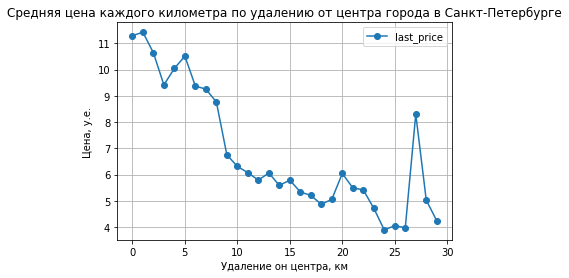

In [67]:
data_spb = data[data['locality_name']=='Санкт-Петербург']
data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price').plot(style = 'o-', grid=True)
plt.title('Средняя цена каждого километра по удалению от центра города в Санкт-Петербурге')
plt.xlabel('Удаление он центра, км')
plt.ylabel('Цена, у.е.');

Заметна тенденция снижнения стоимости квартиры при отдалении адреса от центра города. Пик между 25 и 30 км скорее всего является выбросом, проверим по заданным значениям количество квартир.

In [68]:
data[(data['cityCenters_nearest_km']>25)&(data['last_price']>8)&(data['locality_name']=='Санкт-Петербург')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m,weekday,month,year,floor_type,cityCenters_nearest_km,Количество объявлений,Средняя цена квадратного метра
449,13,14.35,74.0,2017-11-28,2,3.13,5.0,30.0,3,False,False,False,25.0,0.0,Санкт-Петербург,23888.0,27313.0,1.0,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,другой,27.0,15181,110571.382905


Все верно, нашли наш выброс.

### Общий вывод

Распределение средних значений в зависимости от количества комнат в квартире выглядит следующим образом:

In [69]:
table_itog

,Площадь кухни,Цена,Жилая площадь,Общая площадь,Всего объявлений с квартирами
rooms,,,,,
1,9.1,3590000.0,17.6,36.4,8167
2,9.0,4750000.0,30.5,53.0,7908
3,9.1,6100000.0,45.0,72.2,5692
4,10.0,8500000.0,63.6,96.0,1090
5,13.0,12000000.0,89.2,129.8,245


Стоимость квартиры напрямую зависит от ее общей площади, жилой площади, количества комнат, площади кухни. Все эти значения связаны между собой и решющим здесь является стоимость квадратного метра.

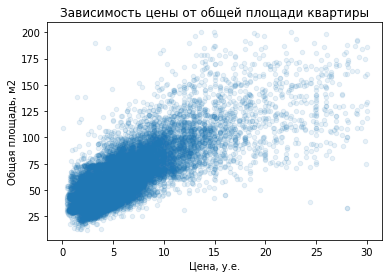

In [70]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.1)
plt.title('Зависимость цены от общей площади квартиры')
plt.xlabel('Цена, у.е.')
plt.ylabel('Общая площадь, м2');

Квартиры с меньшей площадью соответственно стоят дешевле и продаются быстрее, т.к. это требует меньших вложений.

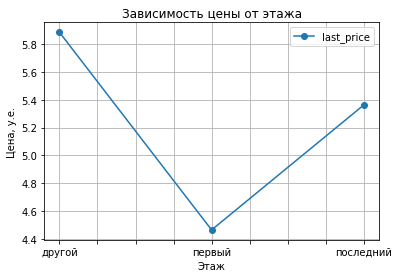

In [71]:
data.pivot_table(index='floor_type', values='last_price').plot(style='o-', grid=True)
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена, у.е.');

Квартиры на первом этаже стоят дешевле, т.к. их покупают неохотнее из-за не самых комфортных условий. Последний этаж в среднем дороже из-за привилегии отсутствия соседий сверху, но все же тоже имеет свои недостатки. Любой другой этаж является золотой серединой для покупателя, но и квартира на нем будет стоить скорре всего дороже.

Что касается времени публикации объявления, выделены следующие особенности:
- Цены выкладываемых квартир на выходных в среднем ниже, чем стоимости квартир, которые были выложены на неделе. Это может быть обусловлено работой агенств недвижимости, которые выкладывают объявления со своей наценкой в будние дни. А частные продавцы выкладывают объявления в свободное от работы время, на выходных, без наценки;
- Объявления о самых дорогих квартирах размещаются в сентябре. Возможно, это связано с началом учебного года, родители покупают своим детям, поступившим в вузы и институты, квартиры для проживания, или же сами после сезона отпусков решаются заняться квартирным вопросом. 
- Минимальная цена в объявлениях о продаже квартир в июне. Возможно, это связано с тем же сезоном отпусков, когда людей мало интересует покупка жилья.
- Касательно года публикации можно заметить, что с 2014 года стоимость жилья сильно упала и не очень активно восстанавливается.

Самые дорогие квартиры в Санкт-Петербурге, далее список по убыванию цены квадратного метра выглядит следующим образом:

In [72]:
data_mean_price_sorted

,Количество объявлений,Средняя цена квадратного метра
locality_name,,
Санкт-Петербург,15181,110571.382905
Пушкин,362,103145.135041
деревня Кудрово,287,92312.310411
поселок Парголово,323,90348.996281
поселок Мурино,549,85503.698732
поселок Шушары,440,78677.364217
Колпино,337,75333.295801
Гатчина,307,68746.146763
Всеволожск,397,68605.572959
